
# Generate simulated evoked data





In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Author: Daniel Strohmeier <daniel.strohmeier@tu-ilmenau.de>
#         Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt


import mne
from mne.datasets import sample
from mne.time_frequency import fit_iir_model_raw
from mne.viz import plot_sparse_source_estimates
from mne.simulation import simulate_sparse_stc, simulate_evoked

print(__doc__)

Automatically created module for IPython interactive environment


Load real data as templates



In [4]:
data_path = sample.data_path()

raw = mne.io.read_raw_fif(data_path + '/MEG/sample/sample_audvis_raw.fif')
proj = mne.read_proj(data_path + '/MEG/sample/sample_audvis_ecg-proj.fif')
raw.info['projs'] += proj
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # mark bad channels

fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
ave_fname = data_path + '/MEG/sample/sample_audvis-no-filter-ave.fif'
cov_fname = data_path + '/MEG/sample/sample_audvis-cov.fif'

fwd = mne.read_forward_solution(fwd_fname)
fwd = mne.pick_types_forward(fwd, meg=True, eeg=True, exclude=raw.info['bads'])
cov = mne.read_cov(cov_fname)
info = mne.io.read_info(ave_fname)

label_names = ['Aud-lh', 'Aud-rh']
labels = [mne.read_label(data_path + '/MEG/sample/labels/%s.label' % ln)
          for ln in label_names]

Successfully extracted to: ['C:\\Users\\djcald.CSENETID\\mne_data\\MNE-sample-data']
Opening raw data file C:\Users\djcald.CSENETID\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
    Read a total of 6 projection items:
        ECG-planar-999--0.200-0.400-PCA-01 (1 x 203)  idle
        ECG-planar-999--0.200-0.400-PCA-02 (1 x 203)  idle
        ECG-axial-999--0.200-0.400-PCA-01 (1 x 102)  idle
        ECG-axial-999--0.200-0.400-PCA-02 (1 x 102)  idle
        ECG-eeg-999--0.200-0.400-PCA-01 (1 x 59)  idle
        ECG-eeg-999--0.200-0.400-PCA-02 (1 x 59)  idle
Reading forward solution from C:\Users\djcald.CSENETID\mne_data\MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics.

Generate source time courses from 2 dipoles and the correspond evoked data



In [5]:
times = np.arange(300, dtype=np.float) / raw.info['sfreq'] - 0.1
rng = np.random.RandomState(42)


def data_fun(times):
    """Function to generate random source time courses"""
    return (50e-9 * np.sin(30. * times) *
            np.exp(- (times - 0.15 + 0.05 * rng.randn(1)) ** 2 / 0.01))


stc = simulate_sparse_stc(fwd['src'], n_dipoles=2, times=times,
                          random_state=42, labels=labels, data_fun=data_fun)

Generate noisy evoked data



In [6]:
picks = mne.pick_types(raw.info, meg=True, exclude='bads')
iir_filter = fit_iir_model_raw(raw, order=5, picks=picks, tmin=60, tmax=180)[1]
nave = 100  # simulate average of 100 epochs
evoked = simulate_evoked(fwd, stc, info, cov, nave=nave, use_cps=True,
                         iir_filter=iir_filter)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Projecting source estimate to sensor space...
[done]


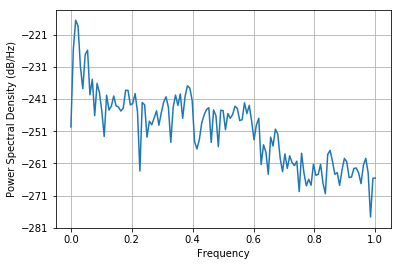

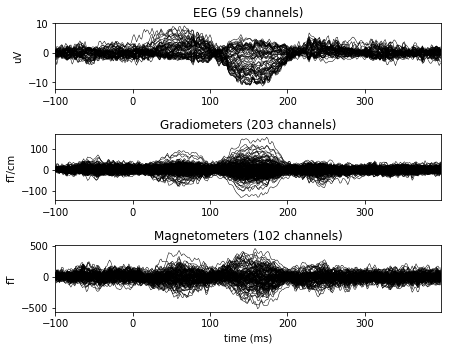

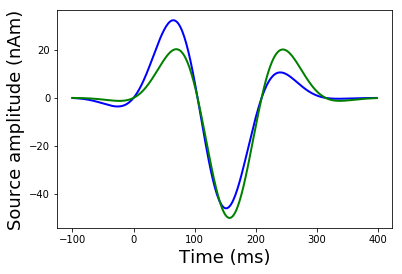

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:

plt.figure()
plt.psd(evoked.data[0])

evoked.plot()

from mayavi import mlab
mlab.init_notebook()

plot_sparse_source_estimates(fwd['src'], stc, bgcolor=(1, 1, 1),
                             opacity=0.5, high_resolution=True)